# Citibike 2019

##Loading Libraries Requirements

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5


     |████████████████████████████████| 102kB 2.5MB/s 
     |████████████████████████████████| 112kB 3.4MB/s 


##Loading Libraries

In [2]:
# Load library
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import zipfile
import urllib.request
import numpy as np
import pandas_profiling
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import category_encoders as ce
pd.set_option('display.max_columns', None)
import glob
from sklearn.metrics import roc_auc_score
import plotly.graph_objects as go
import plotly.express as px

Using TensorFlow backend.


#Loading data

In [3]:
#Loading Station Data

%%time

#Get JSON with Requests
def _getDataFramefromURL(url, entity, index):
    response = requests.request("GET", url)
    json_response = json.loads(response.text)
    df_temp = pd.DataFrame(json_normalize(json_response['data'][entity]))
    df_temp = df_temp.set_index(index) 
    return df_temp

# Get static data from CitiBike from URL
url_station_info = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"
url_system_regions = "https://gbfs.citibikenyc.com/gbfs/en/system_regions.json"

df_station_info = _getDataFramefromURL(url_station_info, 'stations', 'station_id')
df_system_regions = _getDataFramefromURL(url_system_regions, 'regions', 'region_id')

CPU times: user 81.9 ms, sys: 7.45 ms, total: 89.4 ms
Wall time: 486 ms


# Station Info Dataset

In [4]:
df_station_info =df_station_info.reset_index()
df_system_region =df_system_regions.reset_index()
df_station_info.head()

,station_id,external_id,name,short_name,lat,lon,region_id,rental_methods,capacity,rental_url,electric_bike_surcharge_waiver,eightd_has_key_dispenser,eightd_station_services,has_kiosk
0,237,66db3c29-0aca-11e7-82f6-3863bb44ef7c,E 11 St & 2 Ave,5746.04,40.730473,-73.986724,71,"[CREDITCARD, KEY]",39,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': 'e73b6bfb-961f-432c-a61b-8e94c42a1fba'...,True
1,301,66db6aae-0aca-11e7-82f6-3863bb44ef7c,E 2 St & Avenue B,5515.02,40.722174,-73.983688,71,"[CREDITCARD, KEY]",58,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': 'c36f6075-0d24-479b-8018-30790d303769'...,True
2,304,66db6da2-0aca-11e7-82f6-3863bb44ef7c,Broadway & Battery Pl,4962.01,40.704633,-74.013617,71,"[CREDITCARD, KEY]",33,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,True,[{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'...,True
3,307,66db6f2e-0aca-11e7-82f6-3863bb44ef7c,Canal St & Rutgers St,5303.08,40.714275,-73.989900,71,"[CREDITCARD, KEY]",30,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '6196015b-7b16-469e-8b23-405d173765f1'...,True
4,337,66db9925-0aca-11e7-82f6-3863bb44ef7c,Old Slip & Front St,4993.12,40.703799,-74.008387,71,"[CREDITCARD, KEY]",37,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '8ec29d39-9642-466a-9a20-aad1e5c4788a'...,True


Loading Datasets for July, August and September; more than 3 months makes data hard to manage and models to run.

In [5]:
#downloading and unzipping ride data
%%time

files=[#'https://s3.amazonaws.com/tripdata/201901-citibike-tripdata.csv.zip',
      #'https://s3.amazonaws.com/tripdata/201902-citibike-tripdata.csv.zip',
      #'https://s3.amazonaws.com/tripdata/201903-citibike-tripdata.csv.zip',
      #'https://s3.amazonaws.com/tripdata/201904-citibike-tripdata.csv.zip',
      #'https://s3.amazonaws.com/tripdata/201905-citibike-tripdata.csv.zip',
      #'https://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip',
      'https://s3.amazonaws.com/tripdata/201907-citibike-tripdata.csv.zip',
      'https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip',
      'https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip']


for file in files:
  urllib.request.urlretrieve(file, 'data.zip')

  with zipfile.ZipFile('data.zip','r') as zip_ref:
      zip_ref.extractall('./data')
      

CPU times: user 7.81 s, sys: 2.87 s, total: 10.7 s
Wall time: 14.1 s


In [6]:
#loading ride data into dataframe
%%time

data_files=[#'./data/201901-citibike-tripdata.csv',
           #'./data/201902-citibike-tripdata.csv',
           #'./data/201903-citibike-tripdata.csv',
           #'./data/201904-citibike-tripdata.csv',
           #'./data/201905-citibike-tripdata.csv',
           #'./data/201906-citibike-tripdata.csv',
           './data/201907-citibike-tripdata.csv',
           './data/201908-citibike-tripdata.csv',
           './data/201909-citibike-tripdata.csv']

dfs = [pd.read_csv(f) for f in data_files]

df = pd.concat(dfs,ignore_index=True)

print(df.shape)

(6970188, 15)
CPU times: user 20.2 s, sys: 2.35 s, total: 22.5 s
Wall time: 29.2 s


In [7]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,897,2019-07-01 00:00:00.1320,2019-07-01 00:14:58.0040,493.0,W 45 St & 6 Ave,40.756800,-73.982912,454.0,E 51 St & 1 Ave,40.754557,-73.965930,18340,Subscriber,1966,1
1,267,2019-07-01 00:00:05.1780,2019-07-01 00:04:32.4500,3143.0,5 Ave & E 78 St,40.776321,-73.964274,3226.0,W 82 St & Central Park West,40.782750,-73.971370,21458,Customer,1996,1
2,2201,2019-07-01 00:00:05.2130,2019-07-01 00:36:46.7490,317.0,E 6 St & Avenue B,40.724537,-73.981854,3469.0,India St & West St,40.731814,-73.959950,39874,Subscriber,1986,1
3,1660,2019-07-01 00:00:08.6010,2019-07-01 00:27:48.8050,249.0,Harrison St & Hudson St,40.718710,-74.009001,369.0,Washington Pl & 6 Ave,40.732241,-74.000264,38865,Subscriber,1988,1
4,109,2019-07-01 00:00:12.1580,2019-07-01 00:02:01.5670,3552.0,W 113 St & Broadway,40.805973,-73.964928,3538.0,W 110 St & Amsterdam Ave,40.802692,-73.962950,30256,Subscriber,1997,1


In [9]:
#calculating missing values
df.isna().sum()


tripduration                 0
starttime                    0
stoptime                     0
start station id           143
start station name         143
start station latitude       0
start station longitude      0
end station id             143
end station name           143
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64

## Data Cleaning

In [0]:

def engineer_date_features(df):
  df = df.copy()
  times=['starttime','stoptime']
  for t in times:
  # change date_recorded to datetime format
    df[t] = pd.to_datetime(df[t], infer_datetime_format=True)
  for t in times: 
    df['month_'+t] = df[t].dt.strftime('%b')
    df['day_'+t] = df[t].dt.day
    df['weekday_'+t] = df[t].dt.strftime('%a')
    df['hour_'+t] = df[t].dt.hour
    df['minutes_'+t] = df[t].dt.minute
   

  return df
  



def wrangle(df):
#'''cleaning/engineering function'''
    df = df.copy()


#cleaning up data
  
    df = df.dropna(axis='rows')
    df.columns=[col.replace(' ','_') for col in df] #cleaning up naming convention
    df = engineer_date_features(df)
    #dropping features
    drop_features = ['stoptime','starttime']
    df = df.drop(columns=drop_features)
    df['determinant']=abs(df['start_station_latitude']-df['end_station_latitude'])+abs(df['end_station_longitude']-df['start_station_longitude'])
    df['minutes_bin_start_time'] = np.where(df['minutes_starttime']<15,0,
                                           np.where(df['minutes_starttime']<30,15,
                                                     np.where(df['minutes_starttime']<45,30,45)))
    
    df['minutes_bin_stop_time'] = np.where(df['minutes_stoptime']<15,0,
                                           np.where(df['minutes_stoptime']<30,15,
                                                     np.where(df['minutes_stoptime']<45,30,45)))
 
    return df

In [11]:
#applying wrangle
%%time
df1=wrangle(df)
print(df1.shape)


(6970045, 26)
CPU times: user 2min 15s, sys: 7.48 s, total: 2min 22s
Wall time: 2min 22s


In [12]:
#taking a look at the wrangled dataset
df1.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_starttime,month_stoptime,day_stoptime,weekday_stoptime,hour_stoptime,minutes_stoptime,determinant,minutes_bin_start_time,minutes_bin_stop_time
0,897,493.0,W 45 St & 6 Ave,40.756800,-73.982912,454.0,E 51 St & 1 Ave,40.754557,-73.965930,18340,Subscriber,1966,1,Jul,1,Mon,0,0,Jul,1,Mon,0,14,0.019225,0,0
1,267,3143.0,5 Ave & E 78 St,40.776321,-73.964274,3226.0,W 82 St & Central Park West,40.782750,-73.971370,21458,Customer,1996,1,Jul,1,Mon,0,0,Jul,1,Mon,0,4,0.013525,0,0
2,2201,317.0,E 6 St & Avenue B,40.724537,-73.981854,3469.0,India St & West St,40.731814,-73.959950,39874,Subscriber,1986,1,Jul,1,Mon,0,0,Jul,1,Mon,0,36,0.029181,0,30
3,1660,249.0,Harrison St & Hudson St,40.718710,-74.009001,369.0,Washington Pl & 6 Ave,40.732241,-74.000264,38865,Subscriber,1988,1,Jul,1,Mon,0,0,Jul,1,Mon,0,27,0.022268,0,15
4,109,3552.0,W 113 St & Broadway,40.805973,-73.964928,3538.0,W 110 St & Amsterdam Ave,40.802692,-73.962950,30256,Subscriber,1997,1,Jul,1,Mon,0,0,Jul,1,Mon,0,2,0.005259,0,0


In [13]:
#bringing capacity and regional names into the main dataframe
%%time

#making a copy of stations and regions to be brought in, cleaning datatypes to be able to merge, doing this for both start and end stations.
df_capacity_1=df_station_info[['station_id','capacity','region_id']].copy()
df_system_region['region_id']=df_system_region['region_id'].copy().astype(int)
df_capacity_1['region_id']=df_capacity_1['region_id'].copy().astype(int)
df_capacity = pd.merge(df_capacity_1,df_system_region, on='region_id',how='left')
df_capacity_start=df_capacity.copy()
df_capacity_start.columns=['start_station_id', 'start_capacity', 'start_region_id', 'start_region_name']
df_capacity_start['start_station_id']=df_capacity_start['start_station_id'].copy().astype(int)
df_capacity_end=df_capacity.copy()
df_capacity_end.columns=['end_station_id', 'end_capacity', 'end_region_id', 'end_region_name']
df_capacity_end['end_station_id']=df_capacity_end['end_station_id'].copy().astype(int)

#merging capacity and regions into the wrangled dataset
df2 = pd.merge(df1,df_capacity_start, on='start_station_id',how='left')
df3=pd.merge(df2,df_capacity_end, on='end_station_id',how='left')

CPU times: user 12.6 s, sys: 1.15 s, total: 13.8 s
Wall time: 13.8 s


In [14]:
#looking for stations that arent open or have zero capacity
df_capacity_start[df_capacity_start['start_capacity']==0]

,start_station_id,start_capacity,start_region_id,start_region_name
23,72,0,71,NYC District
182,423,0,71,NYC District
194,448,0,71,NYC District
220,480,0,71,NYC District
232,495,0,71,NYC District
279,2023,0,71,NYC District
355,3131,0,71,NYC District
374,3155,0,71,NYC District
457,3286,0,71,NYC District
461,3290,0,71,NYC District


In [15]:
#looking at the completed wrangled dataset
df3.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_starttime,month_stoptime,day_stoptime,weekday_stoptime,hour_stoptime,minutes_stoptime,determinant,minutes_bin_start_time,minutes_bin_stop_time,start_capacity,start_region_id,start_region_name,end_capacity,end_region_id,end_region_name
0,897,493.0,W 45 St & 6 Ave,40.756800,-73.982912,454.0,E 51 St & 1 Ave,40.754557,-73.965930,18340,Subscriber,1966,1,Jul,1,Mon,0,0,Jul,1,Mon,0,14,0.019225,0,0,34.0,71.0,NYC District,35.0,71.0,NYC District
1,267,3143.0,5 Ave & E 78 St,40.776321,-73.964274,3226.0,W 82 St & Central Park West,40.782750,-73.971370,21458,Customer,1996,1,Jul,1,Mon,0,0,Jul,1,Mon,0,4,0.013525,0,0,47.0,71.0,NYC District,NaN,NaN,NaN
2,2201,317.0,E 6 St & Avenue B,40.724537,-73.981854,3469.0,India St & West St,40.731814,-73.959950,39874,Subscriber,1986,1,Jul,1,Mon,0,0,Jul,1,Mon,0,36,0.029181,0,30,54.0,71.0,NYC District,23.0,71.0,NYC District
3,1660,249.0,Harrison St & Hudson St,40.718710,-74.009001,369.0,Washington Pl & 6 Ave,40.732241,-74.000264,38865,Subscriber,1988,1,Jul,1,Mon,0,0,Jul,1,Mon,0,27,0.022268,0,15,27.0,71.0,NYC District,21.0,71.0,NYC District
4,109,3552.0,W 113 St & Broadway,40.805973,-73.964928,3538.0,W 110 St & Amsterdam Ave,40.802692,-73.962950,30256,Subscriber,1997,1,Jul,1,Mon,0,0,Jul,1,Mon,0,2,0.005259,0,0,39.0,71.0,NYC District,45.0,71.0,NYC District


## Trip Dataset

Creating a dataset by selecting all trips according to time and day of the week.

In [0]:
trip_data_weekday_hourly =df3.groupby(['weekday_starttime','hour_starttime']).size().reset_index(name='total_rides')
trip_data_weekday_hourly.columns=['Weekday', 'Hour of the Day', 'Total Rides']


Graphing Rides by Day of the Week according to time

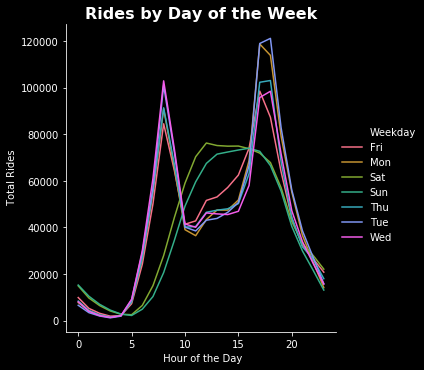

In [32]:
plt.style.use('dark_background')

sns.relplot(x="Hour of the Day", y="Total Rides",
            hue="Weekday",palette="husl",sizes=(10, 100),
            facet_kws=dict(sharex=False),
            kind="line", legend="full", data=trip_data_weekday_hourly);

plt.title('Rides by Day of the Week', fontsize=16, fontweight='bold');
plt.xlabel(' Hour of the Day');
plt.ylabel(' Total Rides');


#Start Data

## Creating the dataset for Start Stations

In [56]:
#creating a dataset for stations where trip start.
start_data =df3.groupby(['start_station_id','start_region_name','start_capacity','month_starttime','day_starttime','weekday_starttime','hour_starttime','minutes_bin_start_time']).size().reset_index(name='rides')
start_data=start_data[start_data['start_capacity']>0].copy()#getting rid of stations with no current capacity
start_data['start_station_usage']=start_data['rides']/start_data['start_capacity']
start_data['usage_level']=np.where(start_data['start_station_usage']>0.25,'High','Low')
start_data=start_data.drop(columns=['rides','start_station_usage','start_capacity'])
start_data.head()

,start_station_id,start_region_name,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_bin_start_time,usage_level
5538,79.0,NYC District,Aug,1,Thu,0,0,Low
5539,79.0,NYC District,Aug,1,Thu,0,45,Low
5540,79.0,NYC District,Aug,1,Thu,4,0,Low
5541,79.0,NYC District,Aug,1,Thu,7,15,Low
5542,79.0,NYC District,Aug,1,Thu,7,30,Low


## Predicting High or Low Level of usage based on capacity

Creating High or Low Usage Levels

Assumption is that at a usage level higher than 25% per 15 minute increment would exhaust a station within an hour without any bikes being refilled or ending at the station.

In [43]:
start_data_g =df3.groupby(['start_station_id','start_region_name','start_capacity','month_starttime','day_starttime','weekday_starttime','hour_starttime','minutes_bin_start_time']).size().reset_index(name='rides')
start_data_g=start_data_g[start_data_g['start_capacity']>0].copy()#getting rid of stations with no current capacity
start_data_g['start_station_usage']=start_data_g['rides']/start_data_g['start_capacity']
start_data_g['usage_level']=np.where(start_data_g['start_station_usage']>0.25,'High','Low')
#cleaning up headers for graphs
start_data_g.columns=['start_station_id', 'start_region_name', 'Station Capacity',
       'month_starttime', 'day_starttime', 'weekday_starttime',
       'hour_starttime', 'minutes_bin_start_time', 'rides',
       'Station Usage', 'Usage Level']
start_data_g.head()

,start_station_id,start_region_name,Station Capacity,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_bin_start_time,rides,Station Usage,Usage Level
5538,79.0,NYC District,33.0,Aug,1,Thu,0,0,2,0.060606,Low
5539,79.0,NYC District,33.0,Aug,1,Thu,0,45,1,0.030303,Low
5540,79.0,NYC District,33.0,Aug,1,Thu,4,0,2,0.060606,Low
5541,79.0,NYC District,33.0,Aug,1,Thu,7,15,1,0.030303,Low
5542,79.0,NYC District,33.0,Aug,1,Thu,7,30,2,0.060606,Low


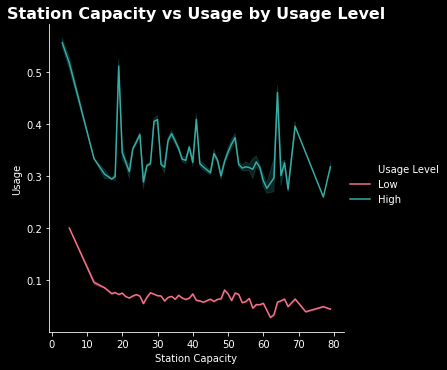

In [44]:
plt.style.use('dark_background')

sns.relplot(x="Station Capacity", y="Station Usage",
            hue="Usage Level",palette="husl",sizes=(10, 100),
            facet_kws=dict(sharex=False),
            kind="line", legend="full", data=start_data_g);

plt.title('Station Capacity vs Usage by Usage Level', fontsize=16, fontweight='bold');
plt.xlabel('Station Capacity');
plt.ylabel('Usage');

We can see that there is a gap between high and low usage levels, signaling that our criteria for 25% holds.

We can see that certain stations with less than 20 capacity likely need more capacity as they see the highest levels of usage.

Baseline of majority classifier for Start Station Data

In [36]:
start_data['usage_level'].value_counts(normalize=True)

Low     0.972346
High    0.027654
Name: usage_level, dtype: float64

High usage only occurs about 2.76% of the time.

In [18]:
start_data.head()

,start_station_id,start_region_name,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_bin_start_time,usage_level
5538,79.0,NYC District,Aug,1,Thu,0,0,Low
5539,79.0,NYC District,Aug,1,Thu,0,45,Low
5540,79.0,NYC District,Aug,1,Thu,4,0,Low
5541,79.0,NYC District,Aug,1,Thu,7,15,Low
5542,79.0,NYC District,Aug,1,Thu,7,30,Low


##Predictive Modeling

## Splitting Data and Checking Dataset Shapes

In [19]:
# Split train into train & val. Make val the same size as test.
target = 'usage_level'
#train, val = train_test_split(start_data,  stratify=start_data[target],train_size=0.75, test_size=0.25, random_state=32)
train=start_data[start_data['month_starttime']=='Jul']
val=start_data[start_data['month_starttime']=='Aug']
test=start_data[start_data['month_starttime']=='Sep']

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

#printing shapes
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (858236, 7)
y_train shape (858236,)
X_val shape (892891, 7)
y_val shape (892891,)
X_test shape (892381, 7)
y_test shape (892381,)


## Pipeline with encoding, applying model and calculating Accuracy and ROC AUC

In [20]:
%%time

transformers = make_pipeline(
    ce.OrdinalEncoder(),
   # SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)
X_test_transformed = transformers.fit_transform(X_test)

model = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=3, 
                            random_state=32, n_jobs=-1)
model.fit(X_train_transformed, y_train)

#validation Accuracy
y_pred = model.predict(X_val_transformed)
print ('Validation Accuracy', accuracy_score(y_val, y_pred))

#Validation ROC AUC
y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
print('Val ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy 0.9753262156299033
Val ROC AUC: 0.8669032877411921
CPU times: user 2min 37s, sys: 312 ms, total: 2min 38s
Wall time: 46.7 s


Validation accuracy is slightly higher than the majority class classifier.

Accuracy score if very high, are we experiencing data leakage? 

## Calculating Accuracy, and ROC AUC for Test Dataset

In [21]:
#validation Accuracy
y_pred = model.predict(X_test_transformed)
print ('Test Accuracy', accuracy_score(y_test, y_pred))

#Validation ROC AUC
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test Accuracy 0.9701147828113776
Test ROC AUC: 0.8428519869491761


Test accuracy is very close to the majority class classifier.

## Permutation Importances

Applying Permutation Importances in order to see if the high validation scores are correlated to any data leakage in case any of the features outweigh the other features in the model.

In [22]:
#permutation importances

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=32
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)


Weight,Feature
0.0066 ± 0.0000,start_station_id
0.0013 ± 0.0000,hour_starttime
0.0005 ± 0.0000,weekday_starttime
0.0001 ± 0.0001,minutes_bin_start_time
0.0000 ± 0.0001,day_starttime
0 ± 0.0000,month_starttime
0 ± 0.0000,start_region_name


We can observe that no one feature clearly out weighs the others which helps us throw out data the hypothesis of data leakage. 

Applying Permutation Importances to Test Dataset

In [23]:


permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=32
)

permuter.fit(X_test_transformed, y_test)
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0074 ± 0.0000,start_station_id
0.0018 ± 0.0001,hour_starttime
0.0006 ± 0.0000,weekday_starttime
0.0001 ± 0.0001,minutes_bin_start_time
0.0001 ± 0.0000,day_starttime
0 ± 0.0000,month_starttime
0 ± 0.0000,start_region_name


#Predictive Modeling for End Data

## Creating the dataset for End Stations

Creating High or Low Usage Levels

Assumption is that at a usage level higher than 25% per 15 minute increment would completely fill a station within an hour without any bikes being removed or starting at the station.

In [24]:
end_data =df3.groupby(['end_station_id','end_region_name','end_capacity','month_stoptime','day_stoptime','weekday_stoptime','hour_stoptime','minutes_bin_stop_time']).size().reset_index(name='rides')
end_data=end_data[end_data['end_capacity']>0].copy()#getting rid of stations with no current capacity
end_data['end_station_usage']=end_data['rides']/end_data['end_capacity']
end_data['usage_level']=np.where(end_data['end_station_usage']>0.25,'High','Low')
end_data=end_data.drop(columns=['rides','end_station_usage','end_capacity'])
end_data.head()

,end_station_id,end_region_name,month_stoptime,day_stoptime,weekday_stoptime,hour_stoptime,minutes_bin_stop_time,usage_level
5722,79.0,NYC District,Aug,1,Thu,0,0,Low
5723,79.0,NYC District,Aug,1,Thu,4,0,Low
5724,79.0,NYC District,Aug,1,Thu,6,15,Low
5725,79.0,NYC District,Aug,1,Thu,7,0,Low
5726,79.0,NYC District,Aug,1,Thu,7,15,Low


Baseline of majority classifier for End Station Data

In [38]:
end_data['usage_level'].value_counts(normalize=True)

Low     0.972052
High    0.027948
Name: usage_level, dtype: float64

High level correctly occurs the same amount of time in both start and end stations.

## Splitting Data and Checking Dataset Shapes

In [25]:
# Split train into train & val. Make val the same size as test.
target = 'usage_level'
#train, val = train_test_split(start_data,  stratify=start_data[target],train_size=0.75, test_size=0.25, random_state=32)
train=end_data[end_data['month_stoptime']=='Jul']
val=end_data[end_data['month_stoptime']=='Aug']
test=end_data[end_data['month_stoptime']=='Sep']

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

#printing shapes
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (861320, 7)
y_train shape (861320,)
X_val shape (896354, 7)
y_val shape (896354,)
X_test shape (895083, 7)
y_test shape (895083,)


## Pipeline with encoding, applying model and calculating Accuracy and ROC AUC

In [26]:
%%time

transformers = make_pipeline(
    ce.OrdinalEncoder(),
   # SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)
X_test_transformed = transformers.fit_transform(X_test)

model = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=3, 
                            random_state=32, n_jobs=-1)
model.fit(X_train_transformed, y_train)

#validation Accuracy
y_pred = model.predict(X_val_transformed)
print ('Validation Accuracy', accuracy_score(y_val, y_pred))

#Validation ROC AUC
y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
print('Val ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy 0.9750556141881445
Val ROC AUC: 0.8717793973430028
CPU times: user 2min 29s, sys: 443 ms, total: 2min 29s
Wall time: 44.9 s


Validation accuracy is slightly higher than the majority class classifier.

Accuracy score if very high, are we experiencing data leakage? 

In [27]:
#validation Accuracy
y_pred = model.predict(X_test_transformed)
print ('Test Accuracy', accuracy_score(y_test, y_pred))

#Validation ROC AUC
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test Accuracy 0.9689213179112999
Test ROC AUC: 0.8464922684303199


Test accuracy is very close to the majority class classifier.

# Permutation Importances

Applying Permutation Importances in order to see if the high validation scores are correlated to any data leakage in case any of the features outweigh the other features in the model.

In [28]:


permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=32
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)


Weight,Feature
0.0058 ± 0.0001,end_station_id
0.0008 ± 0.0000,hour_stoptime
0.0003 ± 0.0000,weekday_stoptime
0.0001 ± 0.0000,minutes_bin_stop_time
0 ± 0.0000,month_stoptime
0 ± 0.0000,end_region_name
-0.0000 ± 0.0000,day_stoptime


We again observe that no one feature out weighs the other features. We can therefore discard the hypothesis of dataleakage.

In [29]:


permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=32
)

permuter.fit(X_test_transformed, y_test)
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0061 ± 0.0000,end_station_id
0.0010 ± 0.0001,hour_stoptime
0.0003 ± 0.0001,weekday_stoptime
0.0001 ± 0.0000,minutes_bin_stop_time
0.0000 ± 0.0000,day_stoptime
0 ± 0.0000,month_stoptime
0 ± 0.0000,end_region_name


Seems like Stations and not regions dictate the bike traffic.

# Further Data Exploration and Discovery

Further exploring into morning commute trips and distance of these trips.

In [30]:
#dataset header
df3.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,month_starttime,day_starttime,weekday_starttime,hour_starttime,minutes_starttime,month_stoptime,day_stoptime,weekday_stoptime,hour_stoptime,minutes_stoptime,determinant,minutes_bin_start_time,minutes_bin_stop_time,start_capacity,start_region_id,start_region_name,end_capacity,end_region_id,end_region_name
0,897,493.0,W 45 St & 6 Ave,40.756800,-73.982912,454.0,E 51 St & 1 Ave,40.754557,-73.965930,18340,Subscriber,1966,1,Jul,1,Mon,0,0,Jul,1,Mon,0,14,0.019225,0,0,34.0,71.0,NYC District,35.0,71.0,NYC District
1,267,3143.0,5 Ave & E 78 St,40.776321,-73.964274,3226.0,W 82 St & Central Park West,40.782750,-73.971370,21458,Customer,1996,1,Jul,1,Mon,0,0,Jul,1,Mon,0,4,0.013525,0,0,47.0,71.0,NYC District,NaN,NaN,NaN
2,2201,317.0,E 6 St & Avenue B,40.724537,-73.981854,3469.0,India St & West St,40.731814,-73.959950,39874,Subscriber,1986,1,Jul,1,Mon,0,0,Jul,1,Mon,0,36,0.029181,0,30,54.0,71.0,NYC District,23.0,71.0,NYC District
3,1660,249.0,Harrison St & Hudson St,40.718710,-74.009001,369.0,Washington Pl & 6 Ave,40.732241,-74.000264,38865,Subscriber,1988,1,Jul,1,Mon,0,0,Jul,1,Mon,0,27,0.022268,0,15,27.0,71.0,NYC District,21.0,71.0,NYC District
4,109,3552.0,W 113 St & Broadway,40.805973,-73.964928,3538.0,W 110 St & Amsterdam Ave,40.802692,-73.962950,30256,Subscriber,1997,1,Jul,1,Mon,0,0,Jul,1,Mon,0,2,0.005259,0,0,39.0,71.0,NYC District,45.0,71.0,NYC District


# Commute Trips

Creating a dataset for trips during morning commute times of 6 to 10 AM and selecting top 30 trips.

In [0]:
df4=df3[df3['hour_starttime']>5]
df4=df4[df4['hour_starttime']<11]

df4.head()
trip_data_commute =df4.groupby(['start_station_name','end_station_name','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']).size().reset_index(name='total_rides')
trip_data_commute_s=trip_data_commute.sort_values(by = 'total_rides',ascending=False).head(30)

Graphing on Plotly the Start Stations of Top 30 Commute Trips

In [34]:
token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig = px.scatter_mapbox(trip_data_commute_s, lat="start_station_latitude", lon="start_station_longitude", hover_name="start_station_name", hover_data=["total_rides"], color_discrete_sequence=["lightgreen"], zoom=12, height=500)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Graphing on Plotly the End Stations of Top 30 Commute Trips

In [40]:

token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig = px.scatter_mapbox(trip_data_commute_s, lat="end_station_latitude", lon="end_station_longitude", hover_name="end_station_name", hover_data=["total_rides"], color_discrete_sequence=["red"], zoom=12, height=500)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Enhancing Dataset with Latitude and Longitude Pairs for Stations

In [41]:
#enhancing dataset with Longitude and Latitude for both Start and End Statins
trip_data_commute_s['trip_longitude'] = list(zip(trip_data_commute_s.start_station_longitude,trip_data_commute_s.end_station_longitude))
trip_data_commute_s['trip_latitude'] = list(zip(trip_data_commute_s.start_station_latitude,trip_data_commute_s.end_station_latitude))
trip_data_commute_s=trip_data_commute_s.copy().reset_index()
trip_data_commute_s.tail()

,index,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,total_rides,trip_longitude,trip_latitude
25,53208,E 102 St & 1 Ave,2 Ave & E 96 St,40.786995,-73.941648,40.783964,-73.947167,584,"(-73.94164802, -73.94716729999999)","(40.7869946, 40.7839636)"
26,110763,Newtown Ave & 23 St,31 St & Newtown Ave,40.771361,-73.924615,40.767549,-73.920933,572,"(-73.9246145, -73.92093345522879)","(40.7713615, 40.7675487799971)"
27,63027,E 32 St & Park Ave,E 33 St & 1 Ave,40.745712,-73.981948,40.743227,-73.974498,566,"(-73.98194829, -73.97449783980845)","(40.745712100000006, 40.74322681432173)"
28,91833,Hudson St & Reade St,North Moore St & Greenwich St,40.716250,-74.009106,40.720195,-74.010301,551,"(-74.0091059, -74.0103006362915)","(40.71625008, 40.72019521437465)"
29,136707,W 20 St & 11 Ave,West St & Chambers St,40.746745,-74.007756,40.717548,-74.013221,551,"(-74.007756, -74.01322069)","(40.746745000000004, 40.71754834)"


Graphing on Plotly the Trips of Top 30 Commute Trips

In [42]:


fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = trip_data_commute_s['trip_longitude'][0], 
    lat = trip_data_commute_s['trip_latitude'][0], 
    marker = {'size': 10}))

for i in range(1,30):
  fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",      
    lon = trip_data_commute_s['trip_longitude'][i], 
    lat = trip_data_commute_s['trip_latitude'][i], 
    marker = {'size': 10}))

token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -74.0060, 'lat': 40.7428},
        'zoom': 10.8,
        'style': "dark",
        'accesstoken':token,
    })

fig.show()

# Distances for Commute Trips

Creating a dataset that includes distances incurred during trips according to absolute variance in Latitude and Longitude. Considering routes that have at least 100 trips.

In [0]:

trip_data_commute_g=trip_data_commute.copy()
trip_data_commute_g['distance']=abs(trip_data_commute_g['start_station_latitude']-trip_data_commute_g['end_station_latitude'])+abs(trip_data_commute_g['end_station_longitude']-trip_data_commute_g['start_station_longitude'])
trip_data_commute_g['trip_longitude'] = list(zip(trip_data_commute_g.start_station_longitude,trip_data_commute_g.end_station_longitude))
trip_data_commute_g['trip_latitude'] = list(zip(trip_data_commute_g.start_station_latitude,trip_data_commute_g.end_station_latitude))
trip_data_commute_g=trip_data_commute_g[trip_data_commute_g['total_rides']>100]


## Graphing Long Distance Commute Trips

In [48]:
trip_data_commute_gg=trip_data_commute_g.sort_values(by = 'distance',ascending=False).head(10).reset_index()
trip_data_commute_gg.head(10)

,index,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,total_rides,distance,trip_longitude,trip_latitude
0,30383,Broadway & Moylan Pl,12 Ave & W 40 St,40.814326,-73.959025,40.760875,-74.002777,182,0.097202,"(-73.9590255, -74.00277668)","(40.8143256, 40.76087502)"
1,118346,Riverside Blvd & W 67 St,West St & Chambers St,40.777507,-73.988886,40.717548,-74.013221,132,0.084293,"(-73.98888587951659, -74.01322069)","(40.777507027547976, 40.71754834)"
2,4252,11 Ave & W 59 St,West St & Chambers St,40.771497,-73.990460,40.717548,-74.013221,122,0.076709,"(-73.99046033620834, -74.01322069)","(40.771496710544405, 40.71754834)"
3,4538,12 Ave & W 40 St,Little West St & 1 Pl,40.760875,-74.002777,40.705693,-74.016777,148,0.069183,"(-74.00277668, -74.01677685)","(40.76087502, 40.70569254)"
4,145293,W 52 St & 11 Ave,West St & Chambers St,40.767272,-73.993929,40.717548,-74.013221,159,0.069016,"(-73.99392888, -74.01322069)","(40.76727216, 40.71754834)"
5,4386,12 Ave & W 40 St,Broadway & Battery Pl,40.760875,-74.002777,40.704633,-74.013617,345,0.067082,"(-74.00277668, -74.01361706)","(40.76087502, 40.70463334)"
6,17938,8 Ave & W 31 St,Broadway & Battery Pl,40.750585,-73.994685,40.704633,-74.013617,140,0.064884,"(-73.9946848154068, -74.01361706)","(40.7505853470215, 40.70463334)"
7,65465,E 43 St & 5 Ave,North Moore St & Greenwich St,40.754121,-73.980252,40.720195,-74.010301,137,0.063974,"(-73.98025184869765, -74.0103006362915)","(40.754120810779256, 40.72019521437465)"
8,4574,12 Ave & W 40 St,South End Ave & Liberty St,40.760875,-74.002777,40.711512,-74.015756,164,0.062342,"(-74.00277668, -74.01575600000001)","(40.76087502, 40.711512)"
9,60362,E 20 St & FDR Drive,Old Slip & Front St,40.733143,-73.975739,40.703799,-74.008387,110,0.061991,"(-73.97573881, -74.00838676)","(40.73314259, 40.703799200000006)"


In [46]:


fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = trip_data_commute_gg['trip_longitude'][0], 
    lat = trip_data_commute_gg['trip_latitude'][0], 
    marker = {'size': 10}))
for i in range(1,10):
  fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",      
    lon = trip_data_commute_gg['trip_longitude'][i], 
    lat = trip_data_commute_gg['trip_latitude'][i], 
    marker = {'size': 10}))

token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -74.0060, 'lat': 40.7428},
        'zoom': 10.8,
        'style': "dark",
        'accesstoken':token,
    })

fig.show()

## Graphing Short Distance Commute Trips

Selecting Top 10 for Shorter Trips that won't start and end at the same station.

In [49]:
trip_data_commute_g['same']=trip_data_commute_g['start_station_name']==trip_data_commute_g['end_station_name']
trip_data_commute_ggg=trip_data_commute_g[trip_data_commute_g['same']==False].sort_values(by = 'distance',ascending=True).head(10).reset_index()
trip_data_commute_ggg.head(10)

,index,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,total_rides,distance,trip_longitude,trip_latitude,same
0,25543,Barrow St & Hudson St,Christopher St & Greenwich St,40.731724,-74.006744,40.732916,-74.007114,133,0.001561,"(-74.00674436, -74.00711384)","(40.73172428, 40.73291553)",False
1,906,1 Ave & E 30 St,E 33 St & 1 Ave,40.741444,-73.975361,40.743227,-73.974498,152,0.002646,"(-73.97536082, -73.97449783980845)","(40.74144387, 40.74322681432173)",False
2,28977,Bond St & Fulton St,Schermerhorn St & Bond St,40.689622,-73.983043,40.688417,-73.984517,178,0.002678,"(-73.98304268717766, -73.98451656103134)","(40.68962188790333, 40.68841742754083)",False
3,154593,West Thames St,Little West St & 1 Pl,40.708347,-74.017134,40.705693,-74.016777,127,0.003012,"(-74.01713445, -74.01677685)","(40.70834698, 40.70569254)",False
4,34037,Broadway & W 60 St,W 63 St & Broadway,40.769155,-73.981918,40.771639,-73.982614,109,0.003179,"(-73.98191841, -73.98261428)","(40.76915505, 40.77163851)",False
5,100675,Lexington Ave & E 26 St,E 24 St & Park Ave S,40.741459,-73.983293,40.740964,-73.986022,154,0.003224,"(-73.983293, -73.98602213)","(40.741459000000006, 40.74096374)",False
6,61279,E 24 St & Park Ave S,Lexington Ave & E 26 St,40.740964,-73.986022,40.741459,-73.983293,268,0.003224,"(-73.98602213, -73.983293)","(40.74096374, 40.741459000000006)",False
7,81058,Franklin St & Dupont St,Huron St & Franklin St,40.735640,-73.958660,40.732660,-73.958260,131,0.003380,"(-73.95866, -73.95826)","(40.735640000000004, 40.732659999999996)",False
8,136655,W 20 St & 11 Ave,W 22 St & 10 Ave,40.746745,-74.007756,40.746920,-74.004519,133,0.003412,"(-74.007756, -74.00451887)","(40.746745000000004, 40.74691959)",False
9,19029,9 Ave & W 18 St,W 17 St & 8 Ave,40.743174,-74.003664,40.741776,-74.001497,111,0.003565,"(-74.00366443, -74.00149746)","(40.74317449, 40.74177603)",False


In [50]:

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = trip_data_commute_ggg['trip_longitude'][0], 
    lat = trip_data_commute_ggg['trip_latitude'][0], 
    marker = {'size': 10}))
for i in range(1,10):
  fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",      
    lon = trip_data_commute_ggg['trip_longitude'][i], 
    lat = trip_data_commute_ggg['trip_latitude'][i], 
    marker = {'size': 10}))

token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -74.0060, 'lat': 40.7428},
        'zoom': 10.8,
        'style': "dark",
        'accesstoken':token,
    })

fig.show()

## Graphing for Trips around the Median Distance Commute Trips

Dataset Selecting trips that were 10% above and below the Median Distance for Commute Trips.

In [51]:
trip_data_commute_g['distance'].median() #Median

0.01360802999999322

In [52]:
trip_data_commute_gg1=trip_data_commute_g[trip_data_commute_g['distance']<(trip_data_commute_g['distance'].median()+trip_data_commute_g['distance'].median()*0.1)]
trip_data_commute_gg1=trip_data_commute_gg1[trip_data_commute_gg1['distance']>(trip_data_commute_g['distance'].median()-trip_data_commute_g['distance'].median()*0.1)]
trip_data_commute_gg1=trip_data_commute_gg1.reset_index()
trip_data_commute_gg1.head()

,index,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,total_rides,distance,trip_longitude,trip_latitude,same
0,252,1 Ave & E 16 St,E 17 St & Broadway,40.732219,-73.981656,40.737050,-73.990093,268,0.013269,"(-73.98165557, -73.99009296)","(40.73221853, 40.73704984)",False
1,262,1 Ave & E 16 St,E 24 St & Park Ave S,40.732219,-73.981656,40.740964,-73.986022,154,0.013112,"(-73.98165557, -73.98602213)","(40.73221853, 40.74096374)",False
2,478,1 Ave & E 18 St,1 Ave & E 30 St,40.733812,-73.980544,40.741444,-73.975361,236,0.012815,"(-73.9805442094803, -73.97536082)","(40.73381219196632, 40.74144387)",False
3,573,1 Ave & E 18 St,E 17 St & Broadway,40.733812,-73.980544,40.737050,-73.990093,273,0.012786,"(-73.9805442094803, -73.99009296)","(40.73381219196632, 40.73704984)",False
4,583,1 Ave & E 18 St,E 24 St & Park Ave S,40.733812,-73.980544,40.740964,-73.986022,184,0.012629,"(-73.9805442094803, -73.98602213)","(40.73381219196632, 40.74096374)",False


In [53]:

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = trip_data_commute_gg1['trip_longitude'][0], 
    lat = trip_data_commute_gg1['trip_latitude'][0], 
    marker = {'size': 10}))
for i in range(1,10):
  fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",      
    lon = trip_data_commute_gg1['trip_longitude'][i], 
    lat = trip_data_commute_gg1['trip_latitude'][i], 
    marker = {'size': 10}))

token ='pk.eyJ1IjoiYWxhc3RyYTMyIiwiYSI6ImNrMjNpem1lbzI1eTYzbWwyMXJjNXZyZzYifQ.G6fW1N9gmG-PF4HJm-9BDw'
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -74.0060, 'lat': 40.7428},
        'zoom': 10.8,
        'style': "dark",
        'accesstoken':token,
    })

fig.show()

Calculation for how the mean of the trips around the median distance compare to the long distance Commute Trips.

In [54]:
trip_data_commute_gg1['distance'].mean()/trip_data_commute_gg['distance'].mean()

0.18960185883775407

Calculation for how the mean of the short distance compare to the long distance Commute Trips.

In [55]:
trip_data_commute_ggg['distance'].mean()/trip_data_commute_gg['distance'].mean()

0.041695636701216635